### This is a notebook for segmenting fiber objects from collagen (or other) channel images. This notebook also provides visualizations and post-processing to extract other relevant fiber features

In [ ]:
import os

import matplotlib.pyplot as plt
from alpineer import load_utils

import ark.segmentation.fiber_segmentation as fibseg
from ark.utils import example_dataset

### Download the Example Dataset

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change the `base_dir` to point to your own sub-directory within the data folder, rather than `'example_dataset'`.

If you would like to stitch images from an external drive, see [External Hard Drives and Google File Stream](https://github.com/angelolab/ark-analysis#external-hard-drives-and-google-file-stream). Otherwise all data, images, files, etc. must be placed in the 'data' directory, and referenced via `'../data/path_to_your_data'`.

* `base_dir`: the path to all of your imaging data. This directory will contain all of the data generated by this notebook.

In [ ]:
base_dir = "../data/example_dataset"

If you would like to test the features in Ark with an example dataset, run the cell below. It will download a dataset consisting of 11 FOVs with 22 channels. You may find more information about the example dataset in the [README](../README.md#example-dataset).

If you are using your own data, skip the cell below.

* `overwrite_existing`: If set to `False`, it will not overwrite existing data in the `data/example_dataset`. Recommended setting to `False` if you have the results of the other notebooks. Set to `True` if you are just running the Example Fiber Segmentation Notebook.

In [ ]:
example_dataset.get_example_dataset(dataset="fiber_segmentation", save_dir=base_dir, overwrite_existing=False)

In [ ]:
input_dir = os.path.join(base_dir, 'image_data')
fibseg_dir = os.path.join(base_dir, 'fiber_segmentation_processed_data')

if not os.path.exists(fibseg_dir):
    os.makedirs(fibseg_dir)

### Here you may load in an example FOV and test the segmentation parameters below, before running on your entire dataset.

The segmentation parameters are as follows:
 - `blur`: Gaussian blur radius used for initial blurring
 - `CSD`: Contrast Scaling Divisor.  This is used to determine the size of the window used for local contrast enhancement.  This should roughly be the length scale (in pixels) of your fibers, and should generally be a power of 2. (i.e 64, 128, 256, etc). 
 - `fiber_widths`: Expected pixel widths of fibers. Be aware that including larger widths can make smaller fibers harder to resolve.
 - `ridge_cutoff`: Intensity cutoff post meijering filtering. Increasing this value will decrease the number of fibers.
 - `sobel_blur`: Determines the elevation map used for watershed segmentation.  Try increasing this if it seems your longer fibers are being divided into smaller fibers
 - `min_fiber_size`: Minimum area of a fiber object.  Objects with an area less than this are removed

In [ ]:
example_fov_name = 'fov2'
fiber_channel_name = 'Collagen1'

blur = 2
CSD = 128
fiber_widths = (1, 3, 5, 7, 9)
ridge_cutoff = 0.1
sobel_blur = 1
min_fiber_size = 100

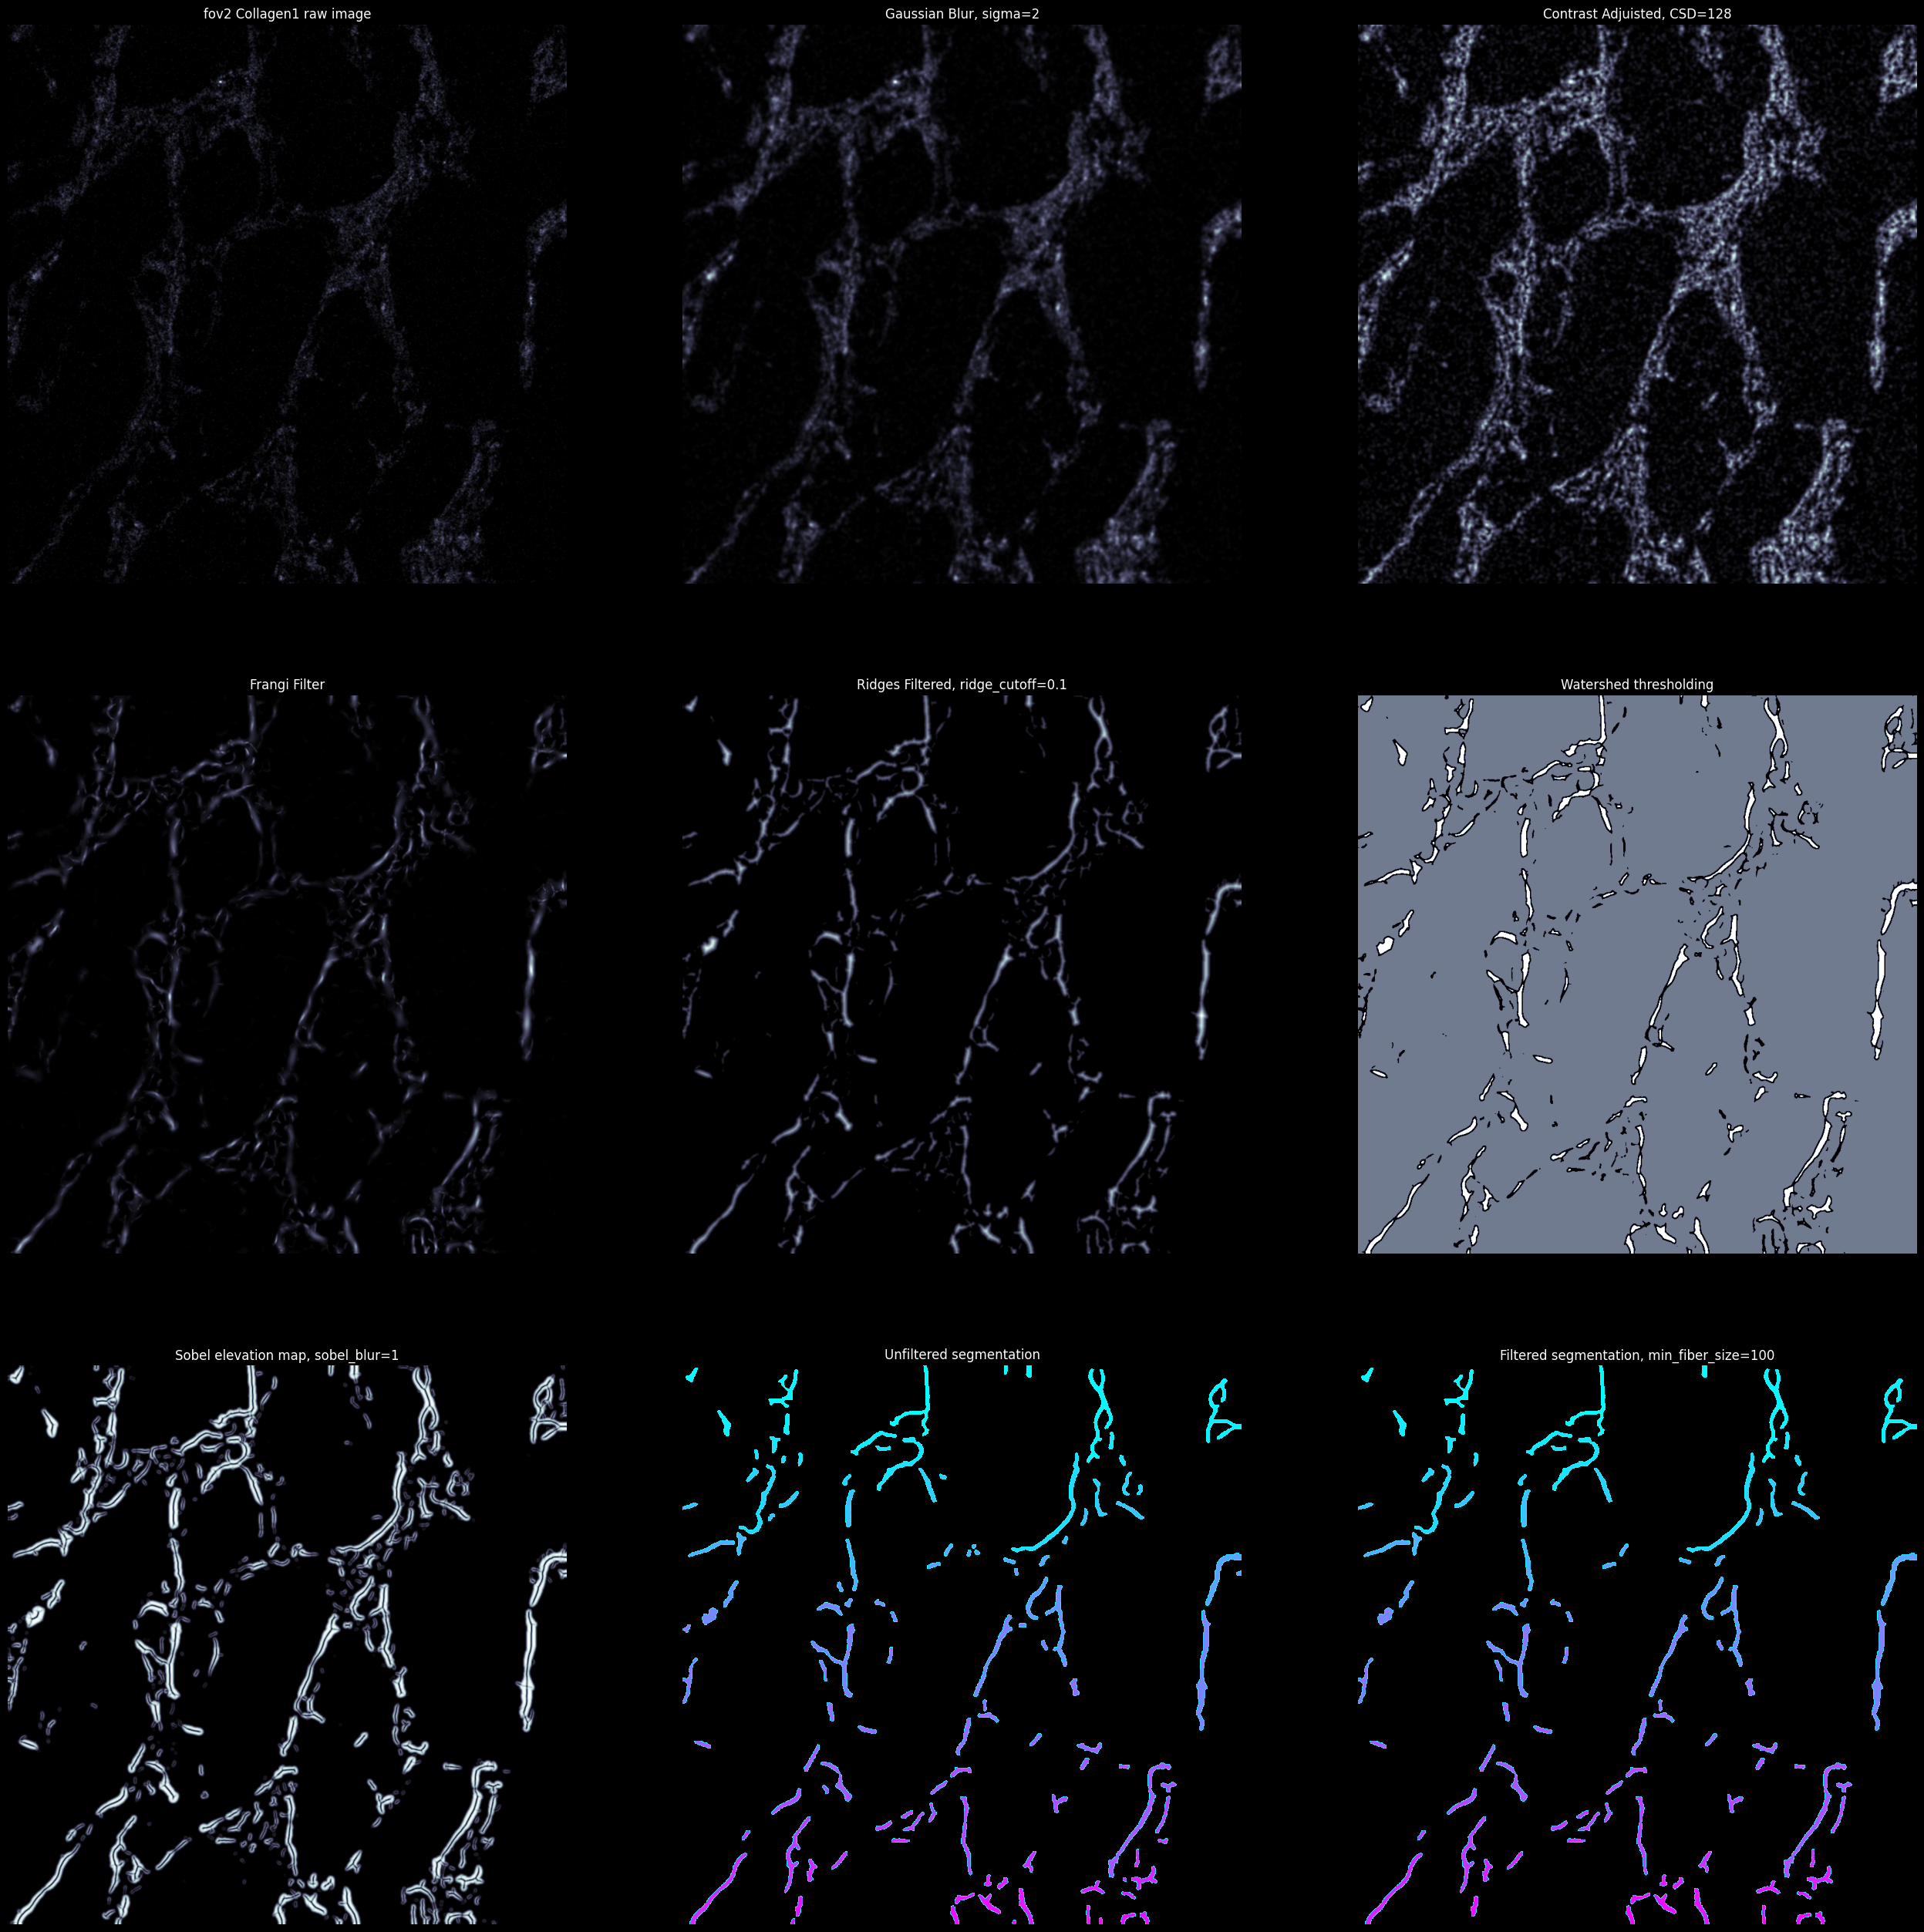

In [9]:
plt.style.use('dark_background')
fibseg.plot_fiber_segmentation_steps(input_dir, example_fov_name, fiber_channel_name,
    img_sub_folder=None,
    blur=blur,
    contrast_scaling_divisor=CSD,
    fiber_widths=fiber_widths,
    ridge_cutoff=ridge_cutoff,
    sobel_blur=sobel_blur,
    min_fiber_size=min_fiber_size
)
plt.gcf().set_size_inches((32, 32))


### This cell performs the segmentation with the above parameters over all of the dataset

If you need to see all of the steps in the segmentation process for each FOV, set `debug=True`. This is not recommended, since this will save 4 additional images per FOV.  But if you suspect there's a problem with the segmentation on certain FOVs, run the `debug=True` flag only a limited subset of your data, or better yet, re-run the above cells on those FOVs.

The function saves the fiber object table as a csv, and the labeled images as tiff files.

In [ ]:
# Set the compression level if desired, ZSTD compression can offer up to a 60-70% reduction in file size.
# NOTE: Compressed `csv` files cannot be opened in Excel. They must be uncompressed beforehand.
csv_compression = None

# Uncomment the line below to allow for compressed `csv` files.
# csv_compression = {"method": "zstd", "level": 3}

fiber_table = fibseg.run_fiber_segmentation(input_dir, fiber_channel_name, fibseg_dir,
    img_sub_folder=None,
    csv_compression=csv_compression,
    blur=blur,
    contrast_scaling_divisor=CSD,
    fiber_widths=fiber_widths,
    ridge_cutoff=ridge_cutoff,
    sobel_blur=sobel_blur,
    min_fiber_size=min_fiber_size,
    debug=False,
)

## Colored Masks
If you would like to examine the fibers the images based on their specific properties, you can do so below. Specify which ones you would like to look at, and a seperate set of masks will be generated for each.

Properties must be one of columns of the fiber object table: `alignment_score`, `major_axis_length`, `minor_axis_length`, `orientation`, `area`, `eccentricity`.

In [ ]:
properties = ['alignment_score']

for prop in properties:
    prop_dir = os.path.join(fibseg_dir, f'colored_{prop}')
    fibseg.color_fibers_by_stat(fiber_table, fibseg_dir, prop_dir, prop)

## Summary Statistics
The cell below will generate files detailing the average length, pixel and fiber count based densities, and the average alignment scores of the fibers. 
`fiber_stats_table.csv` will give the statistics for all fibers in the image while
`fiber_stats_table-tile_*.csv` will give the statistics for fibers within specified size* tiles across the image
- `tile_length`: tile length must be a factor of the image length (i.e. 256, 512, 1024) 
- `min_fiber_num`: the minimum number of fibers located in the tile for statistics to be calculated, otherwise it will recieve an Nan value
- `save_tiles`: whether to save cropped images for which the tile-level stats correspond to

In [ ]:
tile_length = 512
min_fiber_num = 5
save_tiles = True

fov_stats, tile_states = fibseg.generate_summary_stats(
    fiber_table, fibseg_dir, tile_length=tile_length, min_fiber_num=min_fiber_num, save_tiles=save_tiles)